In [ ]:
#Mount Google Drive to access the data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Read the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Beer1.csv')

def process_date(date_str):
    # Extract month, day, and year
    month, day, year = map(int, date_str.split('/'))
    # Add 5 years to the year
    year += 5
    # Return the processed date as a string
    return f"{month}/{day}/{year}"

# Apply the process_date function to the date column
df['date'] = df['date'].apply(process_date)

# Save the modified DataFrame back to a new CSV file
df.to_csv('Castle Lager.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from scipy.stats import reciprocal

In [ ]:
#Load the data
df = pd.read_csv("//content/drive/MyDrive/Castle Lager (1).csv")
df['date'] = pd.to_datetime(df['date'])
print(df.isnull().sum())

date    0
beer    0
dtype: int64


In [ ]:
df.head()

,date,beer
0,1997-01-01,1509
1,1997-02-01,1541
2,1997-03-01,1597
3,1997-04-01,1675
4,1997-05-01,1822


In [ ]:
df.columns.tolist()

['date', 'beer']

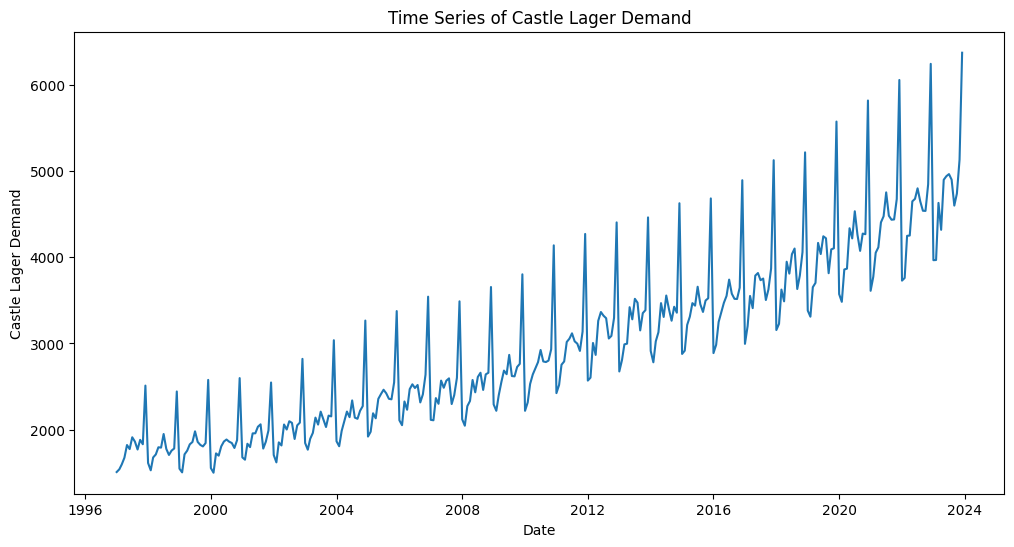

In [ ]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['beer'])
plt.xlabel('Date')
plt.ylabel('Castle Lager Demand')
plt.title('Time Series of Castle Lager Demand')
plt.show()

In [ ]:
# Split data into training (2010-2020) and testing (2021-2023)
train = df[df['date'].dt.year <= 2016]
test = df[df['date'].dt.year >= 2017]

# Extract date and beer consumption for modeling
train_x = train['date']
train_y = train['beer']
test_x = test['date']
test_y = test['beer']


In [ ]:
# Define SVR parameters and adjust as needed
svr_model = SVR(kernel='rbf', C=1000, gamma=0.1)
svr_model.fit(train_x.values.reshape(-1, 1), train_y)

# Predict on training data for visualization (optional)
svr_predicted_train = svr_model.predict(train_x.values.reshape(-1, 1))

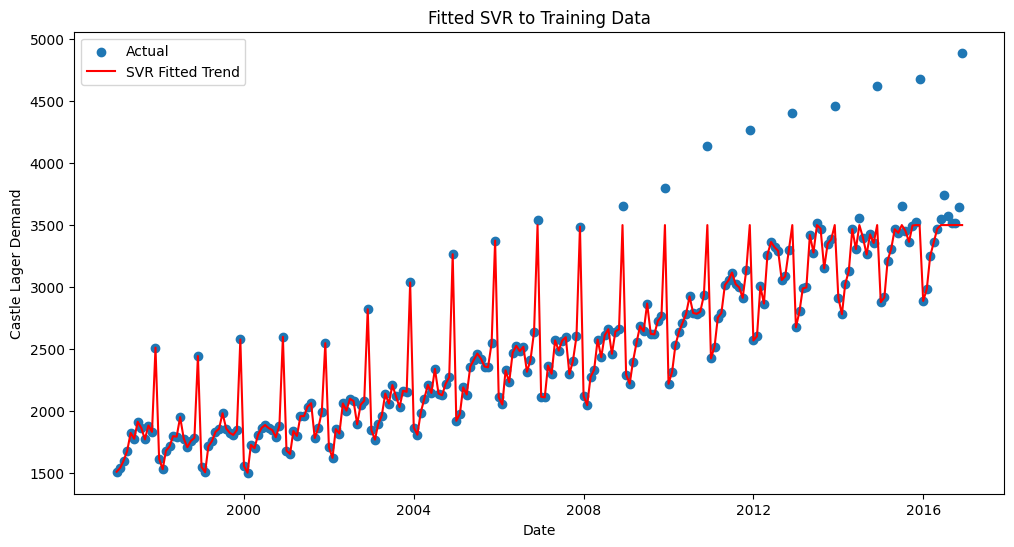

In [ ]:
#svr on training plot
plt.figure(figsize=(12, 6))  # Set the size of the figure
plt.scatter(train_x, train_y, label='Actual')  # Plot the actual data points
plt.plot(train_x, svr_predicted_train, label='SVR Fitted Trend', color='red')  # Plot the SVR fitted trend line
plt.xlabel('Date')  # Label for x-axis
plt.ylabel('Castle Lager Demand')  # Label for y-axis
plt.title('Fitted SVR to Training Data')  # Title of the plot
plt.legend()  # Show legend
plt.show()  # Display the plot


In [ ]:
# Detrend training data using SVR trend
detrended_train = train_y - svr_predicted_train

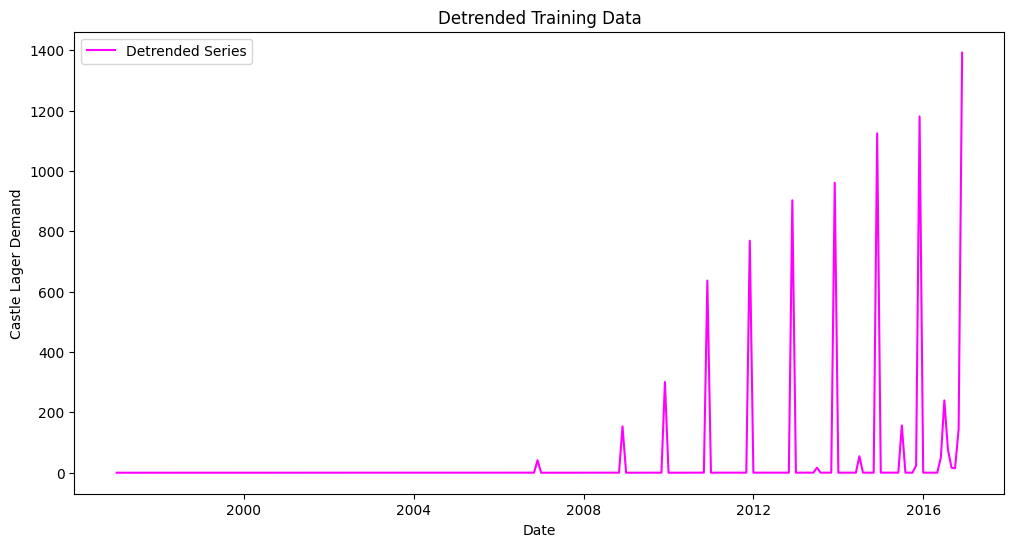

In [ ]:
# Plot detrended_train
plt.figure(figsize=(12, 6))
plt.plot(train_x, detrended_train, label='Detrended Series', color='magenta')
plt.xlabel('Date')
plt.ylabel('Castle Lager Demand')
plt.title('Detrended Training Data')
plt.legend()
plt.show()

In [ ]:
# Conduct Augmented Dickey–Fuller (ADF) test
adf_result = adfuller(train_y)

# Print the ADF statistic
print('ADF Statistic:', adf_result[0])

# Print the p-value
print('p-value:', adf_result[1])

# Print the significance level
alpha = 0.05
if adf_result[1] < alpha:
    print('The detrended series is stationary at the {} level of significance.'.format(alpha))
else:
    print('The detrended series is not stationary at the {} level of significance.'.format(alpha))

ADF Statistic: 0.8921170175460122
p-value: 0.9929865841153301
The detrended series is not stationary at the 0.05 level of significance.


In [ ]:
# Fit SARIMA model to detrended series
sarima_model = ARIMA(detrended_train, order=(2, 0, 0), seasonal_order=(2, 0, 0, 12))
sarima_model_fit = sarima_model.fit()

# Predict on detrended training data for visualization
sarima_predicted_train = sarima_model_fit.predict(start=0, end=len(detrended_train) - 1, dynamic=False)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


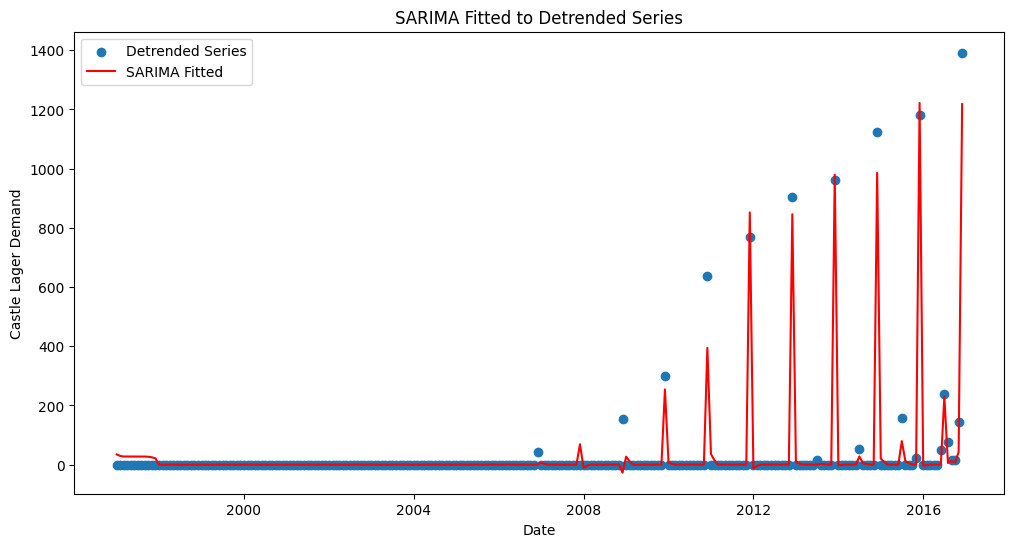

In [ ]:
# Plot SARIMA fitted to detrended series
plt.figure(figsize=(12, 6))
plt.scatter(train_x, detrended_train, label='Detrended Series')
plt.plot(train_x, sarima_predicted_train, label='SARIMA Fitted', color='red')
plt.xlabel('Date')
plt.ylabel('Castle Lager Demand')
plt.title('SARIMA Fitted to Detrended Series')
plt.legend()
plt.show()

In [ ]:
from pmdarima import auto_arima

# Automatic SARIMA model selection using AIC
sarima_model = auto_arima(detrended_train, seasonal=True, m=12, trace=True, error_action='ignore', suppress_warnings=True)

# Fit SARIMA model
sarima_model_fit = sarima_model.fit(detrended_train)

# Forecast using SARIMA model
sarima_forecast = sarima_model_fit.predict(n_periods=len(detrended_train))


In [ ]:
# Generate forecasts using SVR and SARIMA models
svr_forecast = svr_model.predict(train_x.values.reshape(-1, 1))
sarima_forecast = sarima_model_fit.forecast(steps=len(test_y))

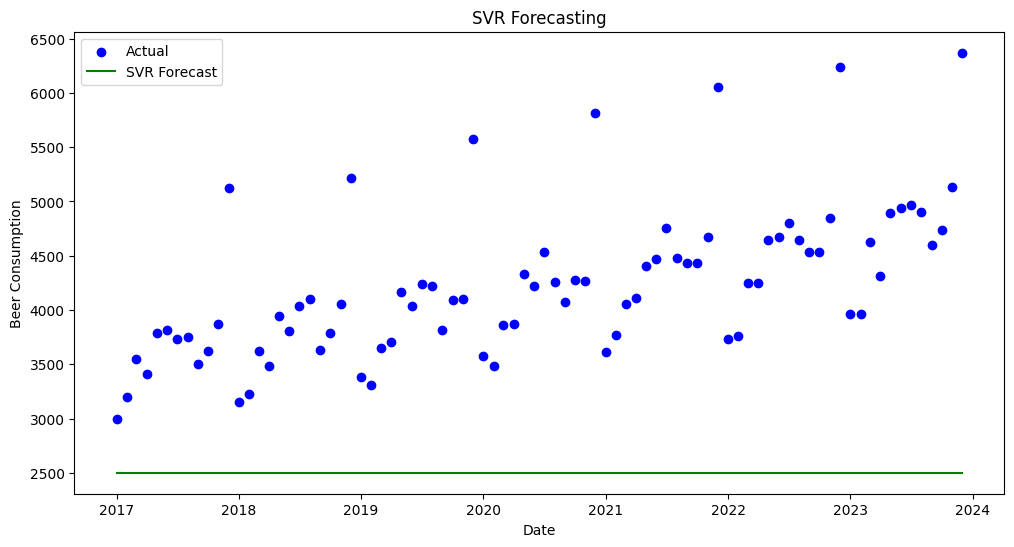

In [ ]:
# Plot SVR forecasting as scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(test_x, test_y, label='Actual', color='blue')
plt.plot(test_x, svr_forecast, label='SVR Forecast', color='green')
plt.xlabel('Date')
plt.ylabel('Beer Consumption')
plt.title('SVR Forecasting')
plt.legend()
plt.show()

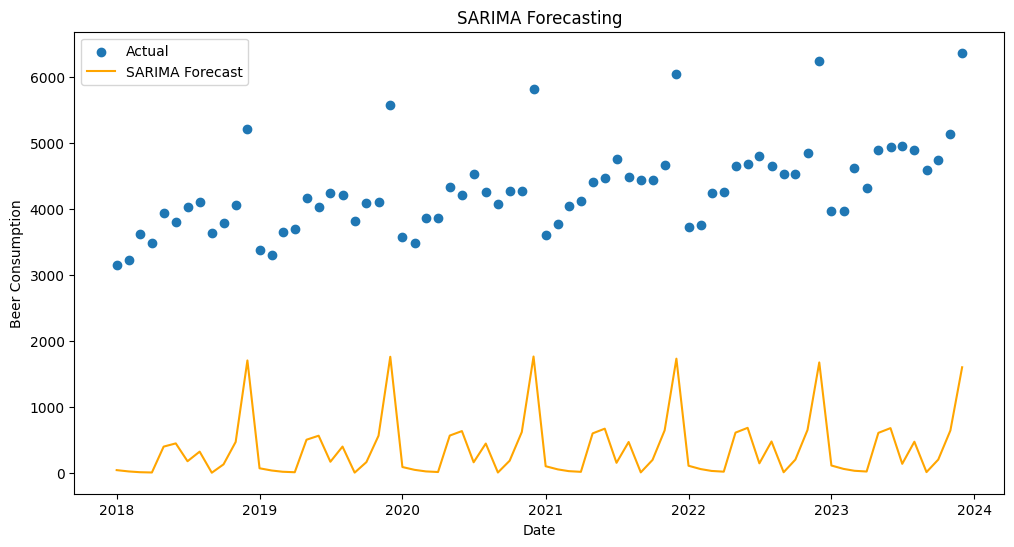

In [ ]:
# Plot SARIMA forecasting
plt.figure(figsize=(12, 6))
plt.scatter(test_x, test_y, label='Actual')
plt.plot(test_x, sarima_forecast, label='SARIMA Forecast',  color='orange')
plt.xlabel('Date')
plt.ylabel('Beer Consumption')
plt.title('SARIMA Forecasting')
plt.legend()
plt.show()

In [ ]:
# Combine forecasts
combined_forecast = svr_forecast + sarima_forecast

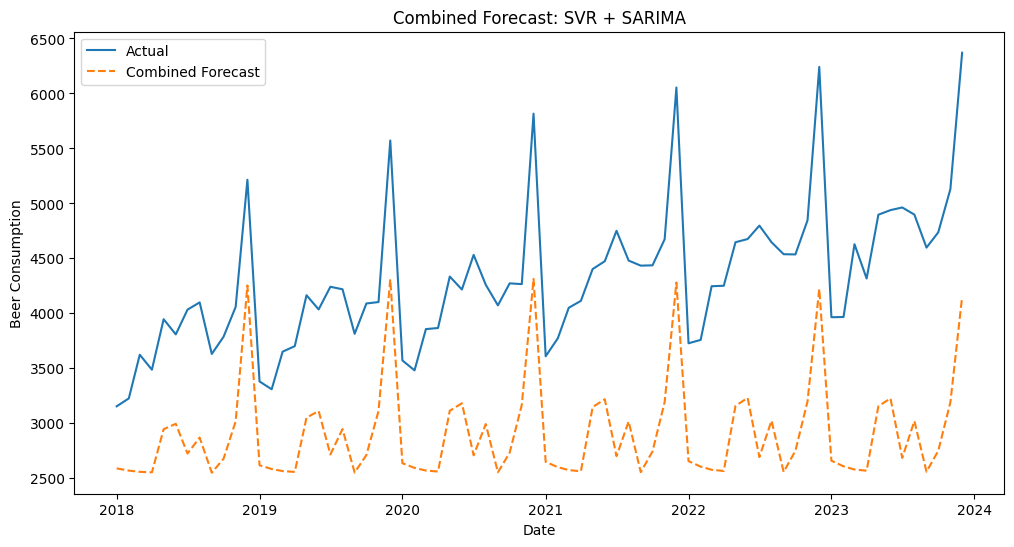

In [ ]:
# Plot combined forecast
plt.figure(figsize=(12, 6))
plt.plot(test_x, test_y, label='Actual')
plt.plot(test_x, combined_forecast, label='Combined Forecast', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Beer Consumption')
plt.title('Combined Forecast: SVR + SARIMA')
plt.legend()
plt.show()

In [ ]:
# Define function to calculate MAPE
def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

# Define function to calculate RMSPE
def calculate_rmspe(actual, forecast):
    return np.sqrt(np.mean(np.square((actual - forecast) / actual))) * 100

# Calculate metrics for SVR model
svr_mape = calculate_mape(test_y, svr_forecast)
svr_rmspe = calculate_rmspe(test_y, svr_forecast)
svr_mse = mean_squared_error(test_y, svr_forecast)
svr_rmse = np.sqrt(svr_mse)
svr_mae = mean_absolute_error(test_y, svr_forecast)

# Calculate metrics for SARIMA model
sarima_mape = calculate_mape(test_y, sarima_forecast)
sarima_rmspe = calculate_rmspe(test_y, sarima_forecast)
sarima_mse = mean_squared_error(test_y, sarima_forecast)
sarima_rmse = np.sqrt(sarima_mse)
sarima_mae = mean_absolute_error(test_y, sarima_forecast)

# Calculate metrics for SVR-SARIMA model
combined_mape = calculate_mape(test_y, combined_forecast)
combined_rmspe = calculate_rmspe(test_y, combined_forecast)
combined_mse = mean_squared_error(test_y, combined_forecast)
combined_rmse = np.sqrt(combined_mse)
combined_mae = mean_absolute_error(test_y, combined_forecast)

# Create table to tabulate the performance metrics
import pandas as pd

data = {
    'Model': ['SVR', 'SARIMA', 'SVR-SARIMA'],
    'MAPE (%)': [svr_mape, sarima_mape, combined_mape],
    'RMSPE (%)': [svr_rmspe, sarima_rmspe, combined_rmspe],
    'MSE': [svr_mse, sarima_mse, combined_mse],
    'RMSE': [svr_rmse, sarima_rmse, combined_rmse],
    'MAE': [svr_mae, sarima_mae, combined_mae]
}

performance_table = pd.DataFrame(data)
print(performance_table)

        Model   MAPE (%)  RMSPE (%)           MSE         RMSE          MAE
0         SVR  39.583845  40.501000  3.539259e+06  1881.291882  1762.183036
1      SARIMA  92.459276  92.834259  1.573694e+07  3966.981090  3946.476687
2  SVR-SARIMA  32.043120  32.733607  2.111872e+06  1453.228045  1396.284723
